# Data Analysis

Let's take a look at what the data from the flight computer looks like. This data was recorded by an Arduino, logging telemetry once per second from the GPS and various sensors sensors and recorded them once a second.  More details and the source code of the flight computer can be located at https://github.com/sea7aero/horizon2.

In [1]:
from preamble import *
%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 5)
plt.rcParams['figure.dpi']= 150

directory = '../data'

# The flight tracker records invalid values as "*", so we want to replace those with Not a Number (NaN).
data = pd.read_csv(directory + '/raw-data.csv', na_values="*")
data.head()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,Unnamed: 19
0,1544,NaN,NaN,NaN,NaN,NaN,NaN,4.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,19.31,93891.82,638.10,42.74,NaN
1,2546,2000.0,0.0,0.0,0.0,0.0,0.0,4.37,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.36,93894.09,637.90,43.11,NaN
2,3547,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.38,93892.00,638.09,42.69,NaN
3,4550,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.39,93899.64,637.41,42.37,NaN
4,5551,2000.0,0.0,0.0,0.0,0.0,0.0,4.40,0.0,99.99,NaN,NaN,NaN,NaN,NaN,19.41,93896.39,637.70,42.41,NaN


## Clean up the data

The raw data is a bit noisy - especially the first dozen seconds or so before the GPS acquired its lock - so the first step is to clean up the invalid data and a few other transformations in order to make it easier to work with.

In [2]:
# The tracker stores each part of the timestamp in a different column. To make it easier for us to work with and
# graph, we convert those columns into a single timestamp column, and make it the index of the Pandas dataframe.
datetime_cols = ["year", "month", "day", "hour", "minute", "second"]
timestamps = data[datetime_cols].apply(lambda x: "{:.0f}-{:.0f}-{:.0f} {:.0f}:{:.0f}:{:.0f}".format(*x), axis=1)
data["timestamp"] = pd.to_datetime(timestamps, errors="coerce")
data.drop(datetime_cols, axis=1)

# The first few rows don't have a valid timestamp at all; we'll just get rid of them.
data = data[data["timestamp"].notnull()]
data.index = data["timestamp"]
data = data.drop(["timestamp"], axis=1)

# # Fill any missing data with the last known value.  Then backfill missing data at the beginning of the file.
data = data.ffill().bfill()

# # Removes the extraneous "unnamed" column.
data = data.dropna(how="all", axis=1)

data.head()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH
timestamp,,,,,,,,,,,,,,,,,,,
2021-09-25 17:26:17,21594,2021.0,9.0,25.0,17.0,26.0,17.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.56,93893.46,637.96,42.33
2021-09-25 17:26:18,22598,2021.0,9.0,25.0,17.0,26.0,18.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.56,93896.89,637.65,42.08
2021-09-25 17:26:19,23600,2021.0,9.0,25.0,17.0,26.0,19.0,4.37,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.58,93898.86,637.48,41.96
2021-09-25 17:26:20,24604,2021.0,9.0,25.0,17.0,26.0,20.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.59,93894.25,637.89,42.06
2021-09-25 17:26:21,25607,2021.0,9.0,25.0,17.0,26.0,21.0,4.40,0.0,99.99,656.1,0.0,0.1,47.160809,-120.84832,19.59,93891.08,638.17,42.25


That's much better, but we turned the tracker on before launch, and that data is kind of boring, so let us compute some interesting time spans and crop our data to just the mission data.

In [3]:
# Figure out the launch time by when it starts ascending.
ascent_rate = data['gps_altitude_m'].diff()
launch_index = np.argmax(ascent_rate > 3)
launch_millis = data['millis'][launch_index]
launch_time = data.index[launch_index]
data['mission_millis'] = data['millis'] - launch_millis

burst_index = np.argmax(data['gps_altitude_m'])
burst_time = data.index[burst_index]

# Figure out the landing time by when it stopped descending.
landing_index = len(ascent_rate) - np.argmax(ascent_rate.iloc[::-1] < -3)
landing_millis = data['millis'][launch_index]
landing_time = data.index[landing_index] # TODO: Determine this value, it may not be the last data.

print("Launch Time (UTC) : {}".format(launch_time))
print("Burst Time        : {}".format(burst_time))
print("Landing Time      : {}".format(landing_time))

ascent_duration = burst_time - launch_time
descent_duration = landing_time - burst_time
mission_duration = ascent_duration + descent_duration

print("Mission Duration  : {}".format(mission_duration))
print("Ascent Duration   : {}".format(ascent_duration))
print("Descent Duration  : {}".format(descent_duration))

Launch Time (UTC) : 2021-09-25 17:28:11
Burst Time        : 2021-09-25 20:04:25
Landing Time      : 2021-09-25 20:41:37
Mission Duration  : 0 days 03:13:26
Ascent Duration   : 0 days 02:36:14
Descent Duration  : 0 days 00:37:12


In [4]:
mission_data = data[launch_index:landing_index]
mission_data.tail()

,millis,year,month,day,hour,minute,second,voltage,satellites,hdop,gps_altitude_m,course,speed_mps,latitude,longitude,temperature_C,pressure_Pa,pressure_altitude_m,humidity_RH,mission_millis
timestamp,,,,,,,,,,,,,,,,,,,,
2021-09-25 20:41:33,11728210,2021.0,9.0,25.0,20.0,41.0,33.0,4.37,12.0,0.73,364.4,34.4,4.8,47.188889,-119.438377,23.58,96866.77,377.97,31.80,11593195
2021-09-25 20:41:34,11729211,2021.0,9.0,25.0,20.0,41.0,34.0,4.37,12.0,0.79,358.9,51.6,3.2,47.188900,-119.438339,23.63,96920.57,373.33,31.76,11594196
2021-09-25 20:41:35,11730215,2021.0,9.0,25.0,20.0,41.0,35.0,4.37,12.0,0.79,353.4,76.4,2.6,47.188892,-119.438301,23.68,96992.07,367.16,31.70,11595200
2021-09-25 20:41:36,11731216,2021.0,9.0,25.0,20.0,41.0,36.0,4.37,12.0,0.90,348.0,97.6,3.0,47.188877,-119.438271,23.73,97054.25,361.80,31.62,11596201
2021-09-25 20:41:37,11732219,2021.0,9.0,25.0,20.0,41.0,37.0,4.37,12.0,0.75,342.9,112.1,3.5,47.188862,-119.438232,23.77,97115.67,356.50,31.64,11597204


## Camera Shutoff

In Graupel-1, we had a failure of the GoPro camera at around the Tropopause.  We determined this was due to the 16850 battery we were using to charge the GoPro getting cold, reducing its output voltage, and causing a shut off.

For Graupel-2, we used a large, commercial external battery bank to power both the GoPro and the flight computer. We insulated the battery with some foam and added a hand warmer for good measure.

It looks like it worked well to keep the battery above critical voltages:

Minium voltage 4.13V


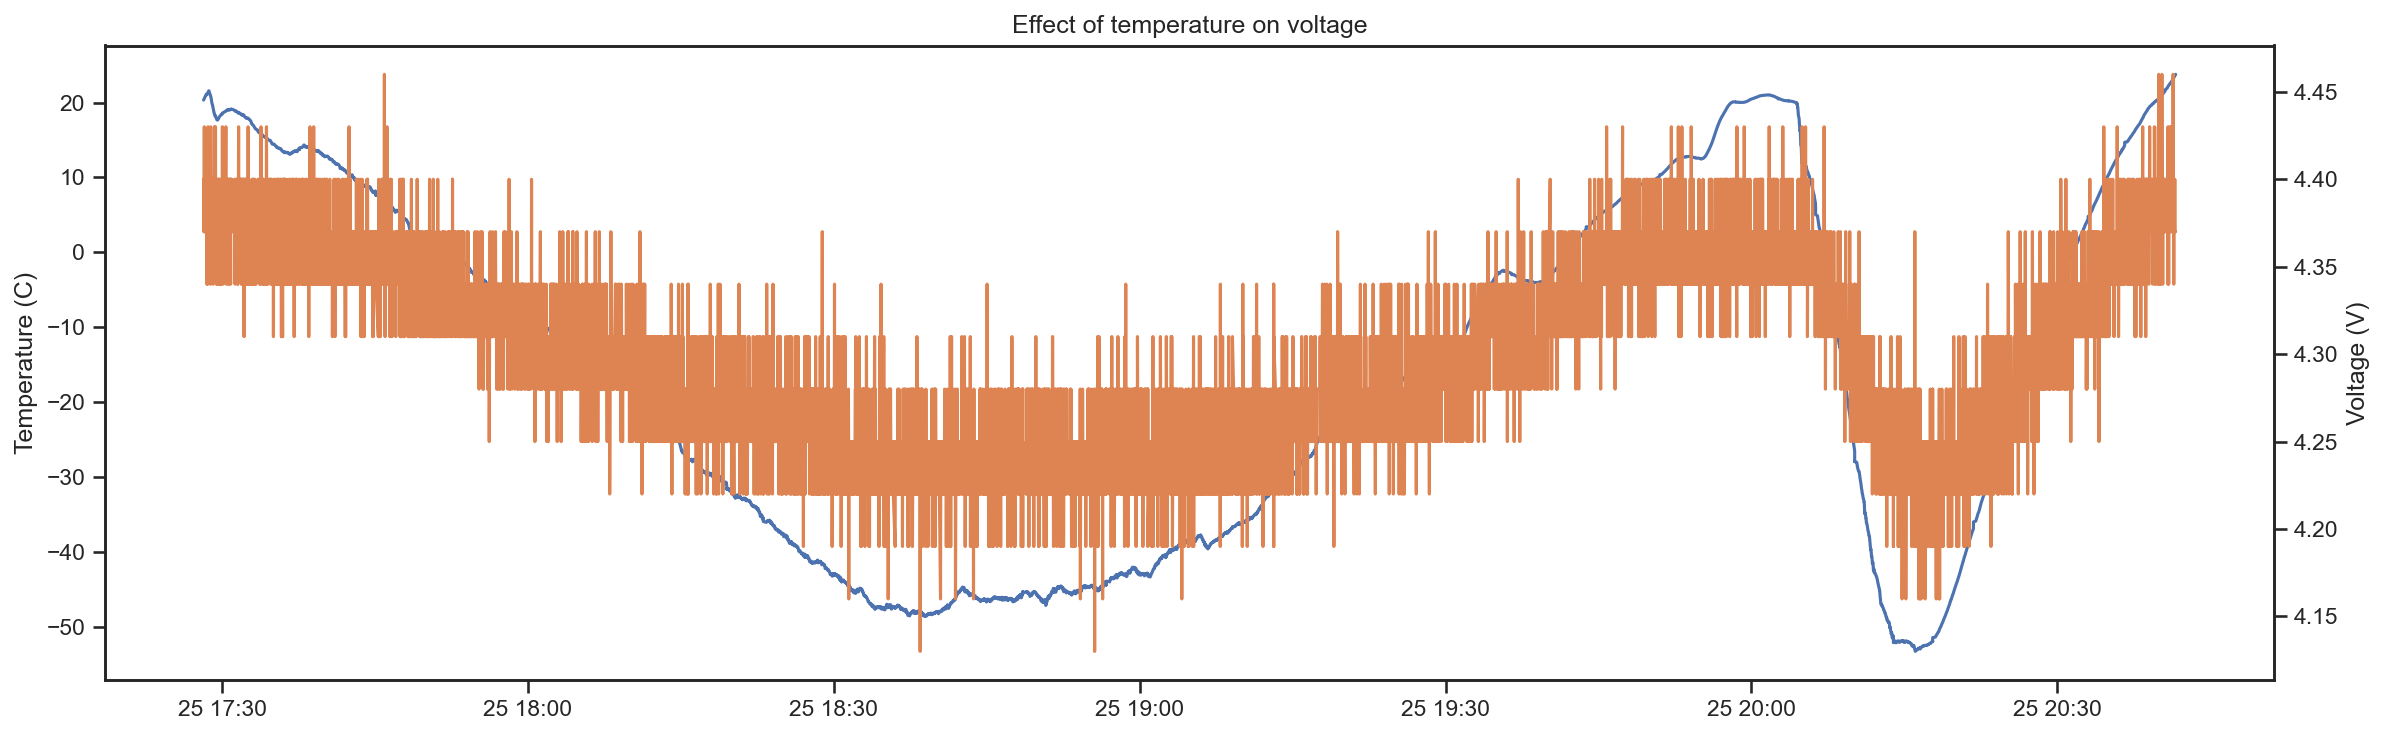

In [5]:
ax = pretty_plots()
ax.plot(mission_data['temperature_C'])
ax2 = ax.twinx()
ax2.plot(mission_data['voltage'], color='C1')
ax.set_title("Effect of temperature on voltage")
ax.set_ylabel("Temperature (C)")
ax2.set_ylabel("Voltage (V)")

print(f"Minium voltage {mission_data['voltage'].min()}V")

## Altitude

The next thing to look at is the altitude, of course. In our case, we have 2 sources of data for the altitude: the value reported by the GPS and a value derived from the barometric pressure sensor.  Let's see what we've got...

Maximum altitude discrepency: 7005 meters


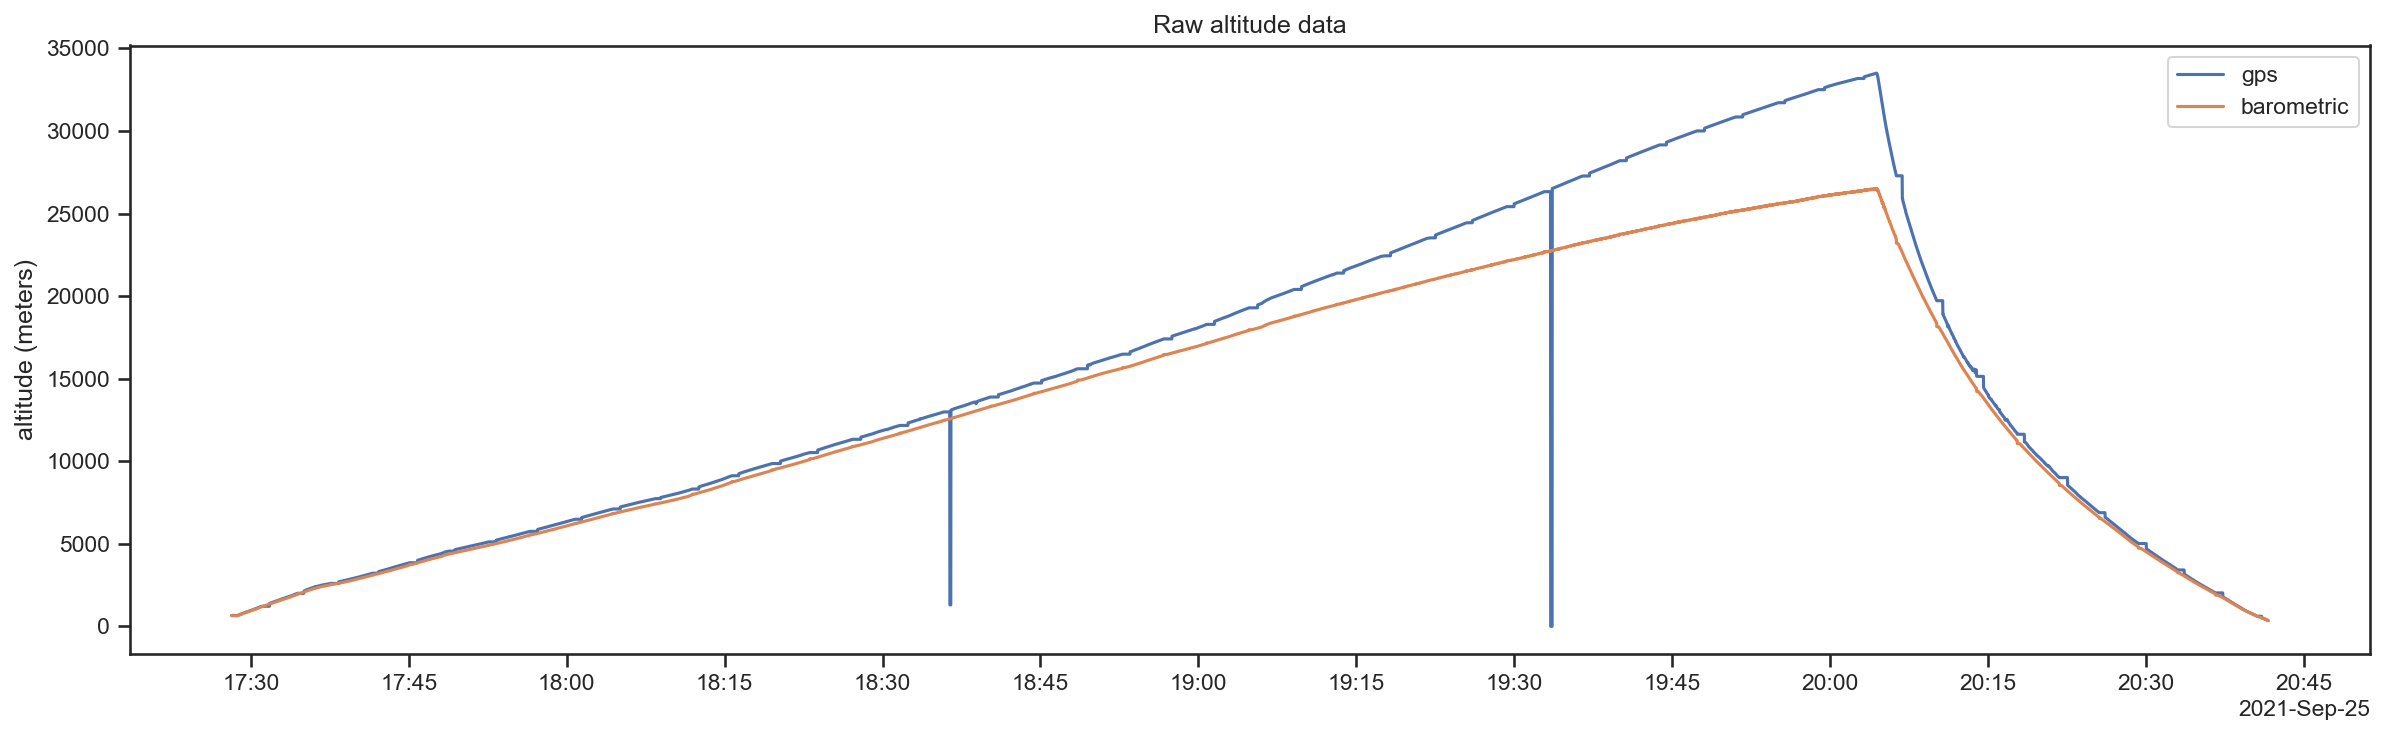

In [6]:
ax = pretty_plots()
ax.plot(mission_data[["gps_altitude_m", "pressure_altitude_m"]])
ax.set_ylabel("altitude (meters)")
ax.legend(["gps", "barometric"])
ax.set_title('Raw altitude data')

difference = (mission_data["gps_altitude_m"] - mission_data["pressure_altitude_m"]).max()
print(f"Maximum altitude discrepency: {difference:.0f} meters")

### Correcting the barometric altitude

From [Graupel-1](https://sea7aero.space/graupel-1), we learned that the tracker computes altitude from the barometric pressue using a naive algorithm that assumes you are in the Troposphere, which is the cause of the variation betweent he two readings.  Let's go ahead and apply what we learned there to this data.

In [7]:
# Here, we're loading up the ISA atmopsheric conditions and defining some constants.
isa = pd.read_csv(directory + '/standard-atmosphere.csv', index_col="layer").sort_values('base_pressure_Pa')

def annotate_layers(ax, label=True, max_layer=10):
    for index, layer in isa.iterrows():
        if(index < max_layer):
            altitude=layer['geopotential_altitude_m']
            ax.axhline(altitude, color='black', ls='-.', lw=0.25)
            if(label):
                ax.text(0.01, altitude+400, layer['name'], transform=ax.get_yaxis_transform())
        
display(isa)

,name,geopotential_altitude_m,geometric_altitude_m,lapse_rate_K_m,base_temperature_C,base_temperature_K,base_pressure_Pa,base_density_kg_m3
layer,,,,,,,,
7,Mesopause,84852,86000,NaN,-86.28,186.87,0.37,NaN
6,Mesosphere,71000,71802,-0.0020,-58.50,214.65,3.96,NaN
5,Mesosphere,51000,51413,-0.0028,-2.50,270.65,66.94,NaN
4,Stratopause,47000,47350,0.0000,-2.50,270.65,110.91,0.0020
3,Stratosphere,32000,32162,0.0028,-44.50,228.65,868.02,0.0132
2,Stratosphere,20000,20063,0.0010,-56.50,216.65,5474.90,0.0880
1,Tropopause,11000,11019,0.0000,-56.50,216.65,22632.00,0.3639
0,Troposphere,-610,-611,-0.0065,19.00,292.15,108900.00,1.2985


In [8]:
universal_gas_constant = 8.31432 # R, N*m/mol*K
molar_mass_dry_air = 0.0289644 # M, kg/mol
gas_constant_dry_air = universal_gas_constant / molar_mass_dry_air
gravitational_acceleration = 9.80665 # g0, m/s^2
# R / g0 * M
altitude_constants = -1.0 * gas_constant_dry_air / gravitational_acceleration

def calc_altitude(pressure):
    layer = isa['base_pressure_Pa'].searchsorted(pressure)
    parameters = isa.iloc[layer]
    base_altitude = parameters['geopotential_altitude_m']
    base_temperature = parameters['base_temperature_K']
    pressure_ratio = pressure / parameters['base_pressure_Pa']
    lapse_rate = parameters['lapse_rate_K_m']
    
    if lapse_rate == 0:
        factor = altitude_constants * base_temperature 
        return base_altitude + factor * math.log(pressure_ratio)
    else:
        factor = base_temperature / lapse_rate
        exponent = altitude_constants * lapse_rate
        return base_altitude + factor * (pow(pressure_ratio, exponent)-1)
    
calc_altitude = np.vectorize(calc_altitude)

In [9]:
# From: https://commons.erau.edu/cgi/viewcontent.cgi?article=1124&context=ijaaa
def calc_altitude_temp_adjusted(pressure_Pa, temperature_C):
    temperature_K = temperature_C + 273.15
    layer = isa['base_pressure_Pa'].searchsorted(pressure_Pa)
    parameters = isa.iloc[layer]
    
    base_altitude_m = parameters['geopotential_altitude_m']
    base_temperature_K = parameters['base_temperature_K']
    temp_ratio = base_temperature_K / temperature_K
    
    pressure_ratio = pressure_Pa / parameters['base_pressure_Pa']
    
    density_ratio = pressure_ratio * temp_ratio
    lapse_rate = parameters['lapse_rate_K_m']
    
    if lapse_rate == 0:
        factor = altitude_constants * base_temperature_K
        return base_altitude_m + factor * math.log(density_ratio)
    else:
        factor = base_temperature_K / lapse_rate
        exponent = altitude_constants * lapse_rate
        return base_altitude_m + factor * (pow(density_ratio, exponent)-1)
    
calc_altitude_temp_adjusted = np.vectorize(calc_altitude_temp_adjusted)


In [10]:
def calc_altitude_blended(pressure_Pa, temperature_C):
    if(pressure_Pa > 22632):
        return calc_altitude(pressure_Pa)
    else:
        return calc_altitude_temp_adjusted(pressure_Pa, temperature_C)
    
calc_altitude_blended = np.vectorize(calc_altitude_blended)

KeyError: "['blended_altitude_m'] not in index"

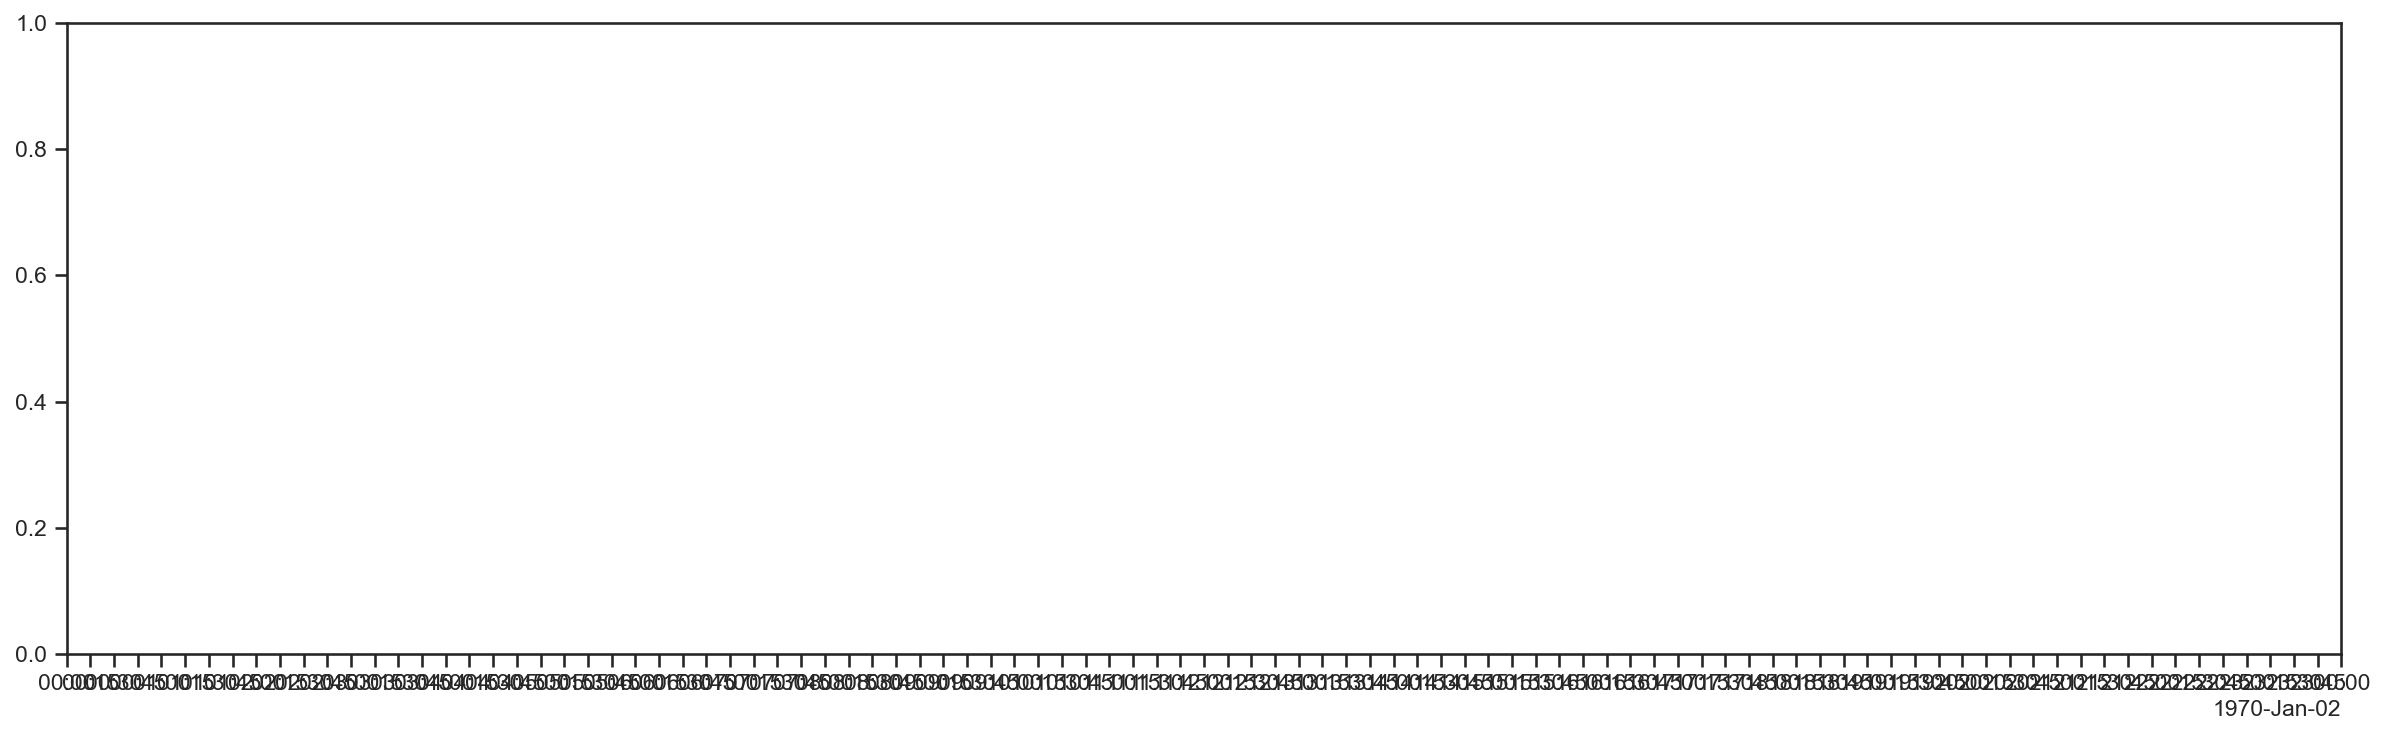

In [11]:
data['blended_altitude_m'] = calc_altitude_blended(data['pressure_Pa'], data['temperature_C'])
ax = pretty_plots()
ax.plot(mission_data[['gps_altitude_m', 'blended_altitude_m']])
ax.set_ylabel("altitude (m)")
ax.legend(["gps", "better barometric"]);
ax.set_title("Temperature adjusted altitude")

difference = mission_data["gps_altitude_m"] - mission_data["blended_altitude_m"]
print(f"Maximum altitude discrepency: {difference.max():.0f} meters")

### GPS altitude noise

Okay, now the barometric altitude looks better, but what about those weird jags in the GPS data?  Those were not there in the Graupel-1 launch.  Let's take a closer look.

In [ ]:
import datetime
window = datetime.timedelta(minutes=30)

def plot_window(title, start, end):
    fig, ax = plt.subplots(tight_layout=True)
    
    locator = mdates.MinuteLocator(byminute=range(60), interval=4)
    formatter = mdates.ConciseDateFormatter(locator)
    ax.xaxis.set_major_locator(locator)
    ax.xaxis.set_major_formatter(formatter)
    
    ax.plot(data[start:end]['gps_altitude_m'])
    ax.set_title(title)
        
plot_window('At launch', launch_time, launch_time + window)
plot_window('Before burst', burst_time - window, burst_time)
plot_window('After burst', burst_time, burst_time + window)
plot_window('At landing', landing_time - window, landing_time)

## Smoothing noise

The noise in the GPS altitude is still a mystery to me.  It seems that roughly every 4 minutes, through the entire flight, the GPS fails to update its altitude.  It does not appear to be correlated to any other data as far as I can tell. If anyone has an idea, I'd love to hear it.

So, the first thing we can do is simply discard the obvious outliers where the GPS data was dropped.

In [ ]:
from hampel import hampel

filtered_altitude = hampel(mission_data['gps_altitude_m'], window_size=10, n=3, imputation=True)
ax = pretty_plots()

ax.plot(mission_data['gps_altitude_m'])
ax.plot(filtered_altitude);

Next, I'm going to use a Kalman filter to smooth out the measurement noise from the GPS by combining it with the
ascent rate from the altimeter.

In [13]:
from filterpy.kalman import KalmanFilter

# Create the measurement array.
x = filtered_altitude
dx = mission_data['pressure_altitude_m'].diff()
zs = np.vstack([x, dx]).T[1:]
N = zs.shape[0]

# Construct a Kalman filter where the dimension of the state variables is 2 (altitude and ascent rate)
# and the number of measured variables is 2 (altitude and ascent rate).
kf = KalmanFilter (dim_x=2, dim_z=2)

# Initial altitude and ascent rate.
kf.x = np.array([x[0], 0.])

dt = 1.
# State transition matrix. Altitude = Previous Altitude + Ascent Rate * dt
kf.F = np.array([[1.,dt],
                [0.,1.]])

# Measurement matrix: we have measurements for both altitude and ascent rate.
kf.H = np.array([[1.,0.],
                [0.,1.]])

kf.P *= 5000
kf.R *= 5

from filterpy.common import Q_discrete_white_noise
kf.Q = Q_discrete_white_noise(dim=2, dt=0.003, var=0.13)

(mu, cov, _, _) = kf.batch_filter(zs) #Rs=[kf.R]*N, Fs=[kf.F]*N, Hs=[kf.H]*N)
(xs, _, _, _) = kf.rts_smoother(mu, cov)

NameError: name 'filtered_altitude' is not defined

NameError: name 'xs' is not defined

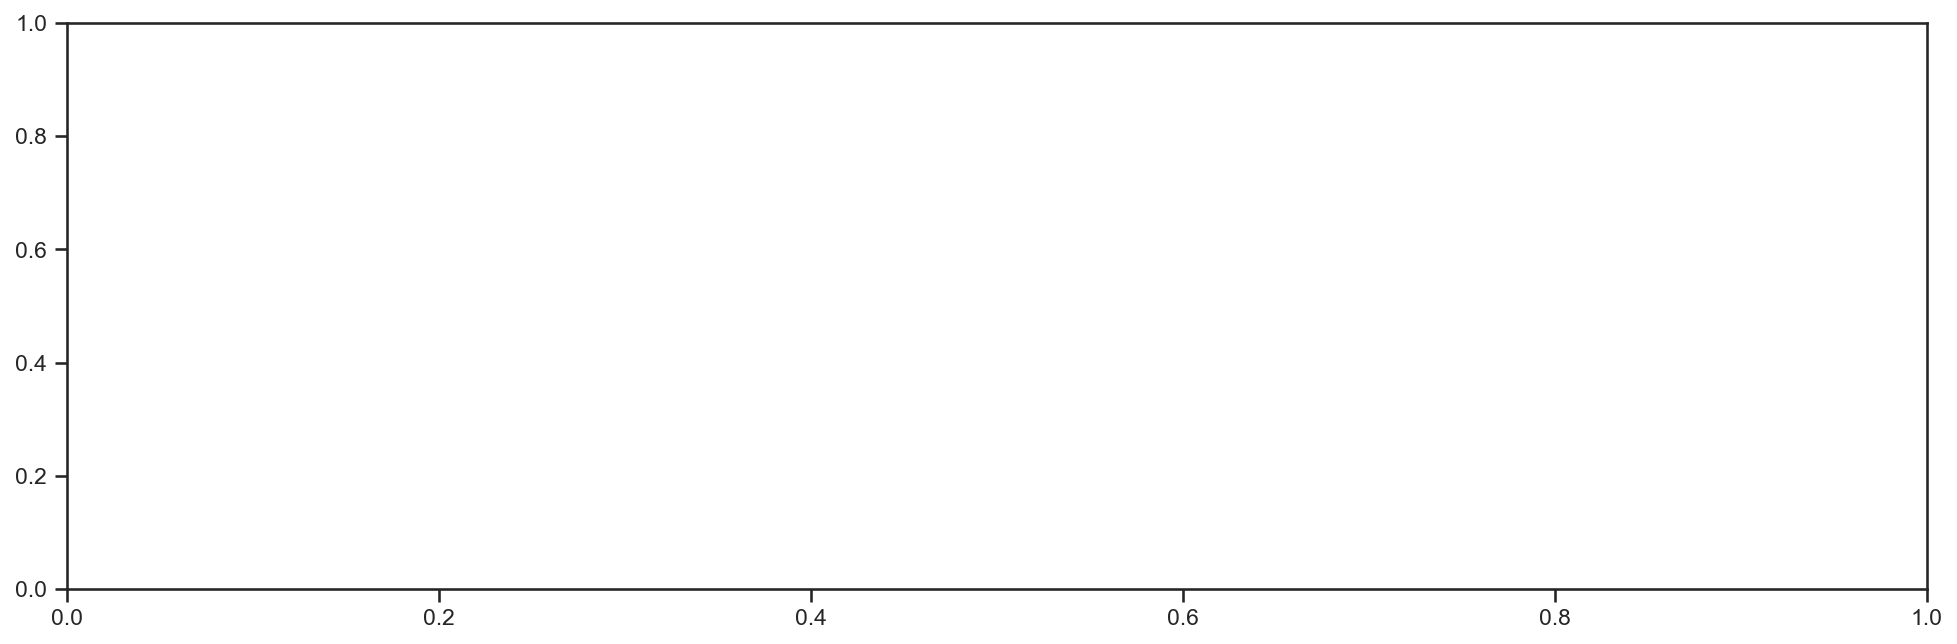

In [12]:
fig, ax = plt.subplots()
ax.plot(xs[1000:10000,0])
print((xs[:,0].max() * units.m).to(units.ft))

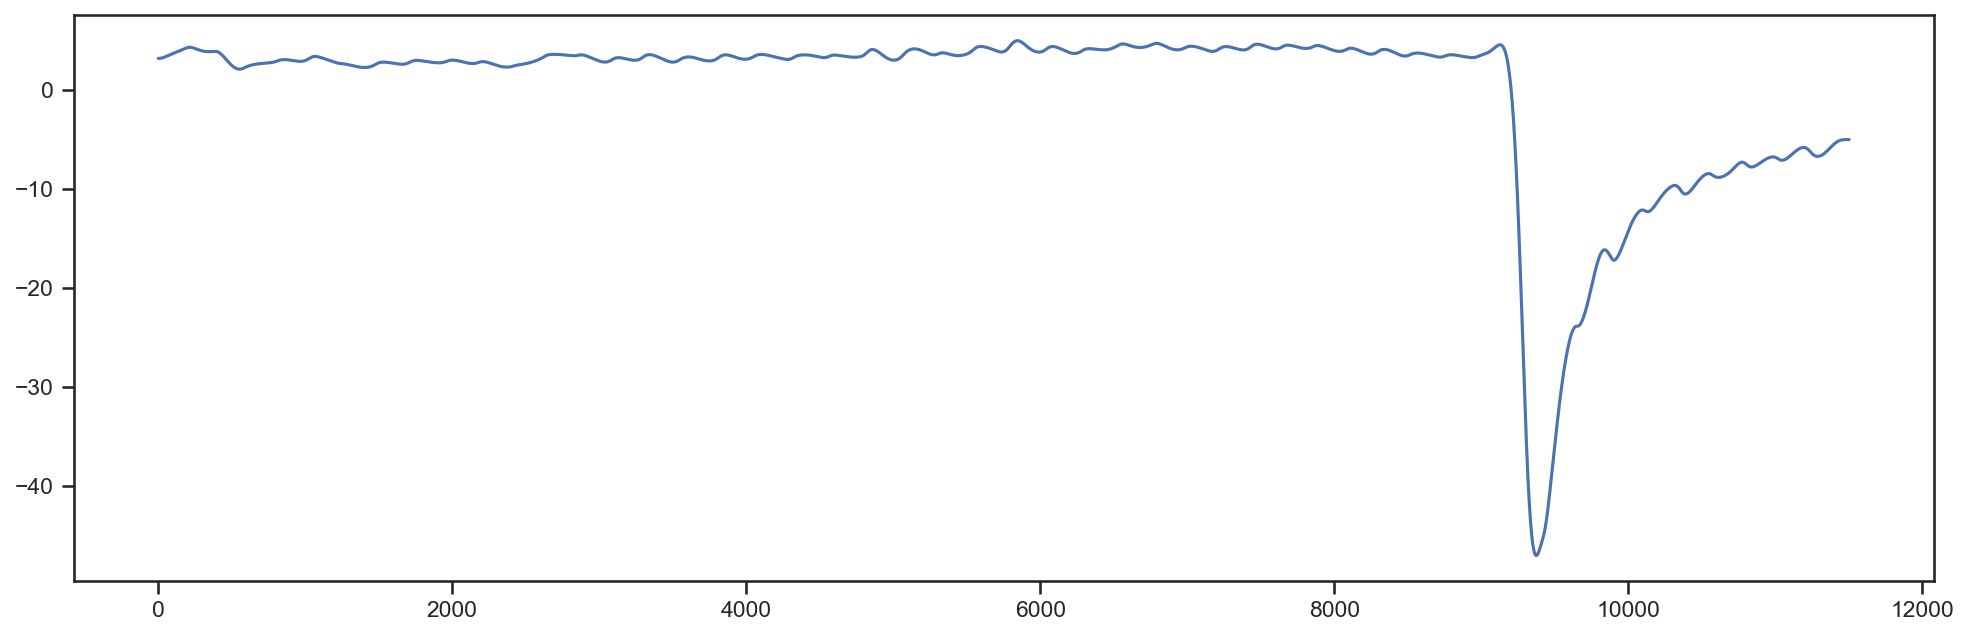

In [553]:
plt.plot(np.diff(xs[:,0]))

Alright, what the heck! Other than some obvious outliers and some noise early in the ascent phase, it seems that the GPS altitude is much more precise over this run, especially as we get into the stratosphere.

Let's take a look at the underlying data: the barometric pressure. Maybe our barometer doesn't work so well at low pressure.

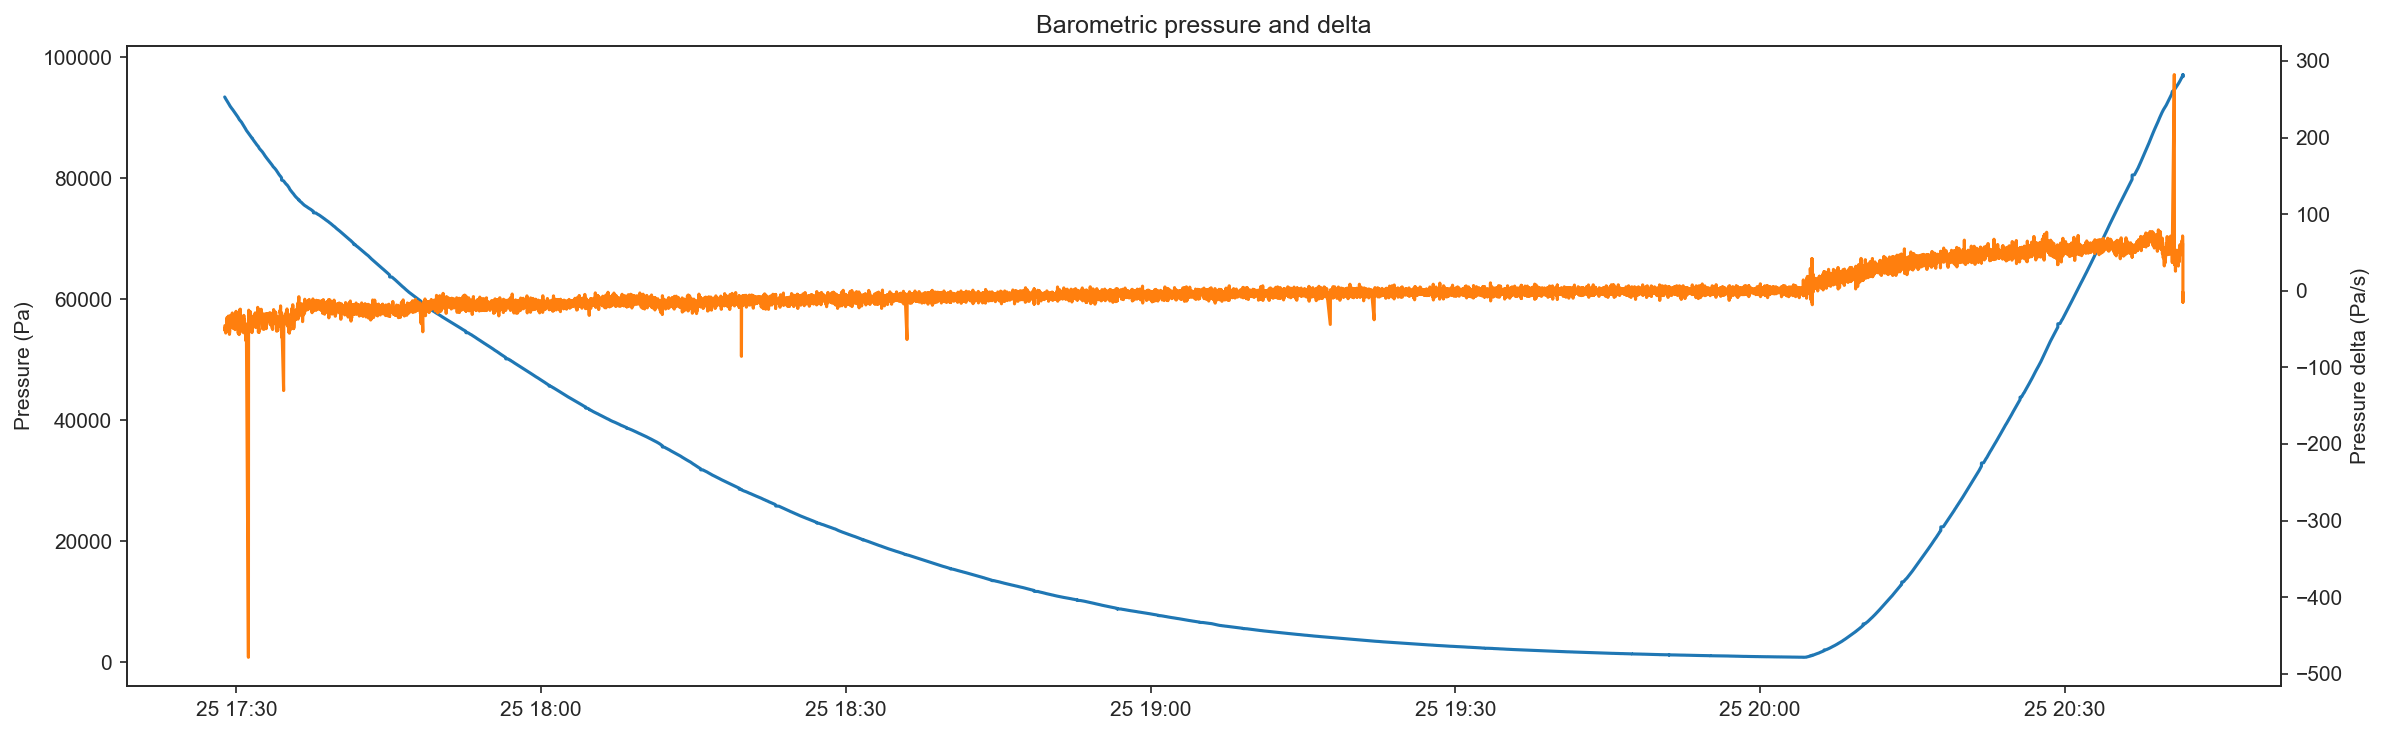

In [33]:
ax = pretty_plots()
ax.plot(mission_data['pressure_Pa'])
ax.set_ylabel("Pressure (Pa)")

ax2 = ax.twinx()
ax2.plot(mission_data['pressure_Pa'].diff(), color="C1")
ax2.set_ylabel("Pressure delta (Pa/s)")

ax.set_title("Barometric pressure and delta");

This seems reasonable enough, apart from noise as our balloon was plummeting through the troposphere. So what's going on?

After some thought, it occured to me that the formula from pressure to altitude is logarithmic! So, a small error in pressure will translate to a larger error as pressure decreases. And this is exactly what we're seeing above.

## Smoothing the altitude

Now, in order to smooth the noise in our altitude reading, I am going to apply an exponential weighted average (EWM) and then combine both the GPS and pressure readings together to get a blend.

The first step is to find an alpha parameter for our EWM that looks suitable. The alpha parameter describes how much weight to apply to the most recent data point compared to the previous data points. An alpha of 1.0 applies no smoothing.

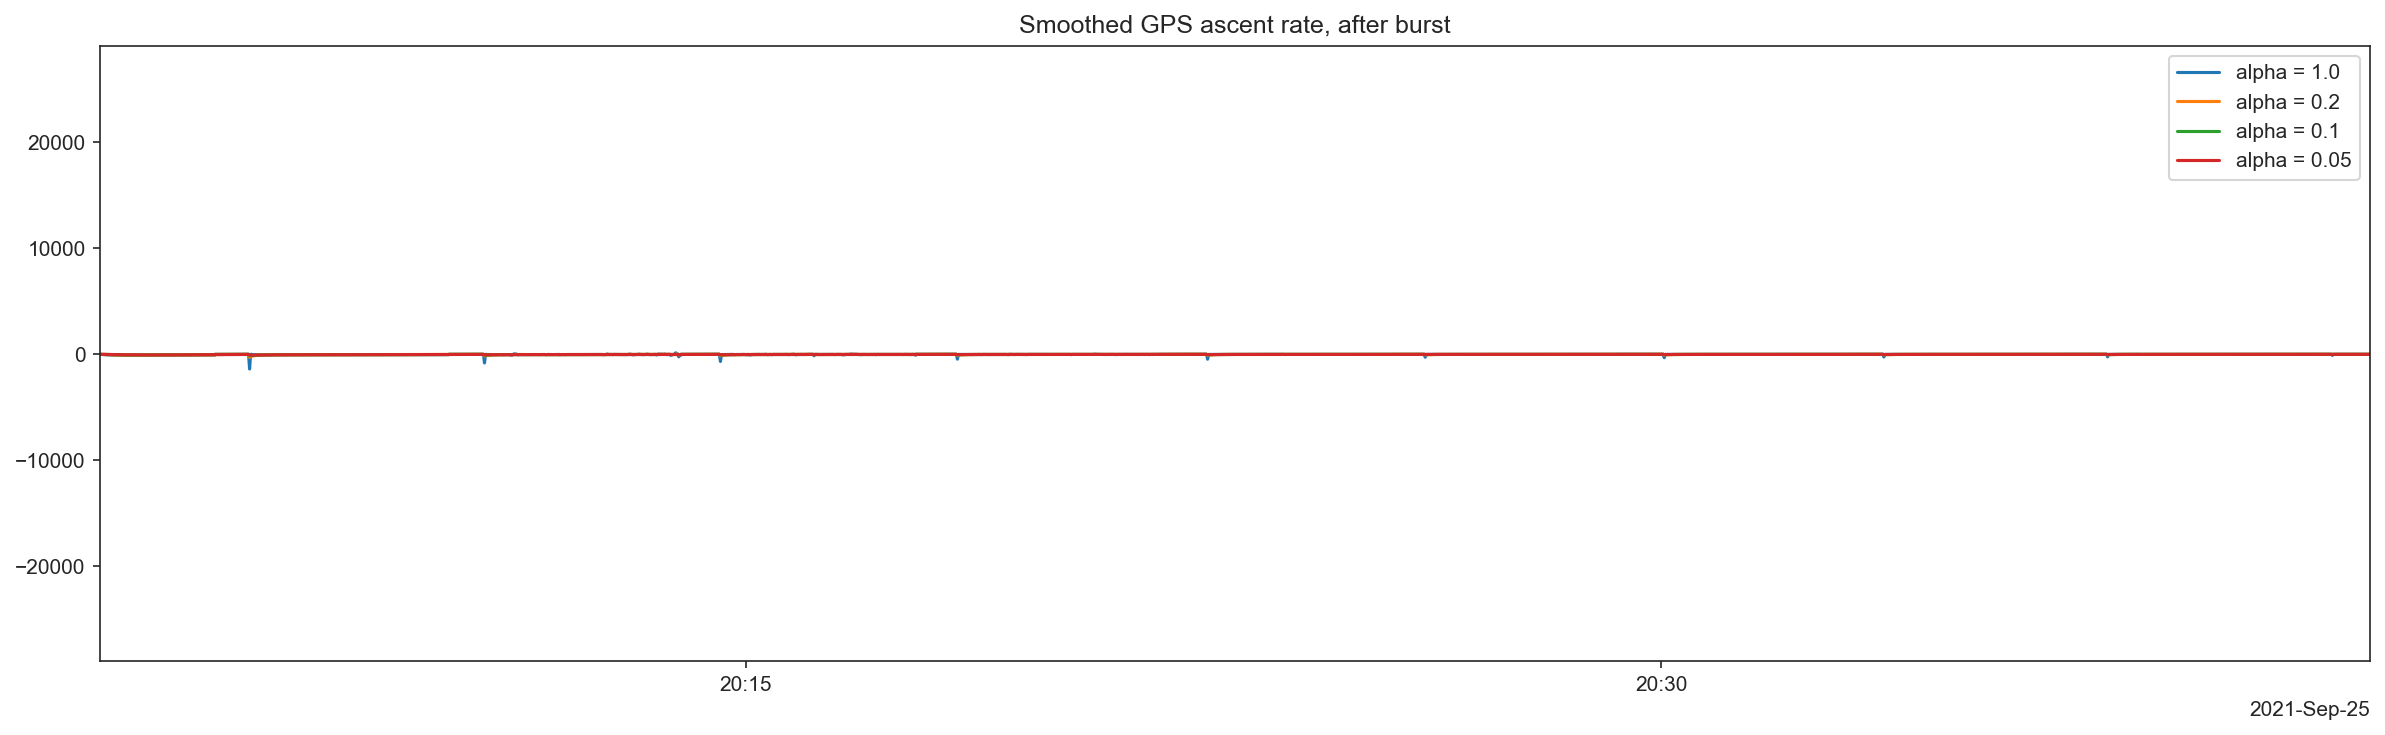

In [34]:
ax = pretty_plots()
ax.set_xlim(burst_time, landing_time)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_gps_data = mission_data['gps_altitude_m'].ewm(alpha=alpha).mean()
    ax.plot(smoothed_gps_data.diff(), label="alpha = {}".format(alpha))

ax.set_title("Smoothed GPS ascent rate, after burst")
ax.legend();

For the GPS altitude, with its spurious outliers, applying an aggressive smoothing looks good, but anything much higher than 0.2 loses the detail during the sudden deceleration phase of the descent (when the balloon pops and starts rocketing through the stratosphere).

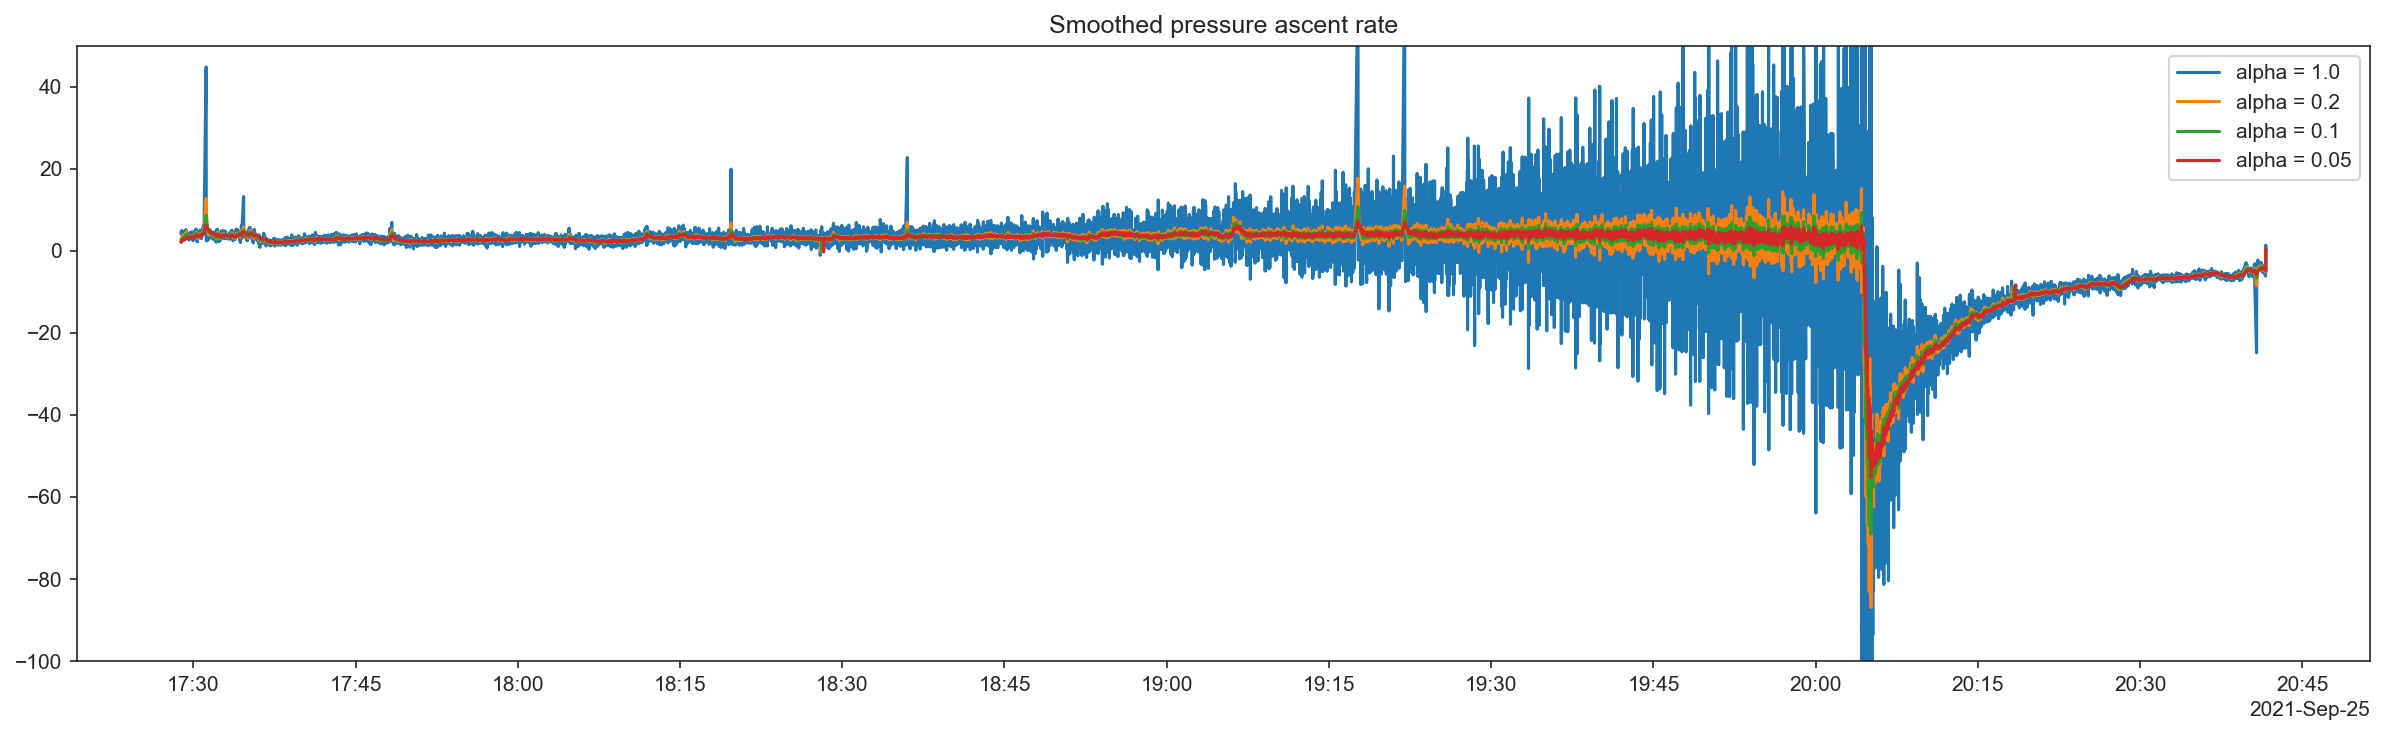

In [35]:
ax = pretty_plots()
ax.set_ylim(-100, 50)

for alpha in [1.0, 0.2, 0.1, 0.05]:
    smoothed_pressure = mission_data['pressure_Pa'].ewm(alpha=alpha).mean()
    smoothed_pressure_altitude = smoothed_pressure.apply(calc_altitude)
    ax.plot(smoothed_pressure_altitude.diff(), label="alpha = {}".format(alpha))
    
ax.set_title("Smoothed pressure ascent rate")
ax.legend();

The noise in the barometric pressure appears much more normally distributed than the GPS (which, as an analog vs digtal device, makes sense), so smoothing seems to work incredibly well here.  Even aggressive values of alpha seem to track the trend very well, with a notable exception of the balloon burst.  I'll choose an alpha of 0.1 here.

In [36]:
mission_data['smoothed_gps_altitude_m'] = mission_data['gps_altitude_m'].ewm(alpha=0.2).mean()
mission_data['smoothed_pressure_Pa'] = mission_data['pressure_Pa'].ewm(alpha=0.1).mean()
mission_data['smoothed_pressure_altitude_m'] = calc_altitude_blended(mission_data['smoothed_pressure_Pa'], mission_data['temperature_C'])

weight = 0.5
mission_data['altitude_m'] = \
    (mission_data['smoothed_gps_altitude_m'] * weight) + \
    (mission_data['smoothed_pressure_altitude_m'] * (1-weight))

/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['smoothed_gps_altitude_m'] = mission_data['gps_altitude_m'].ewm(alpha=0.2).mean()
/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['smoothed_pressure_Pa'] = mission_data['pressure_Pa'].ewm(alpha=0.1).mean()
/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/142227778

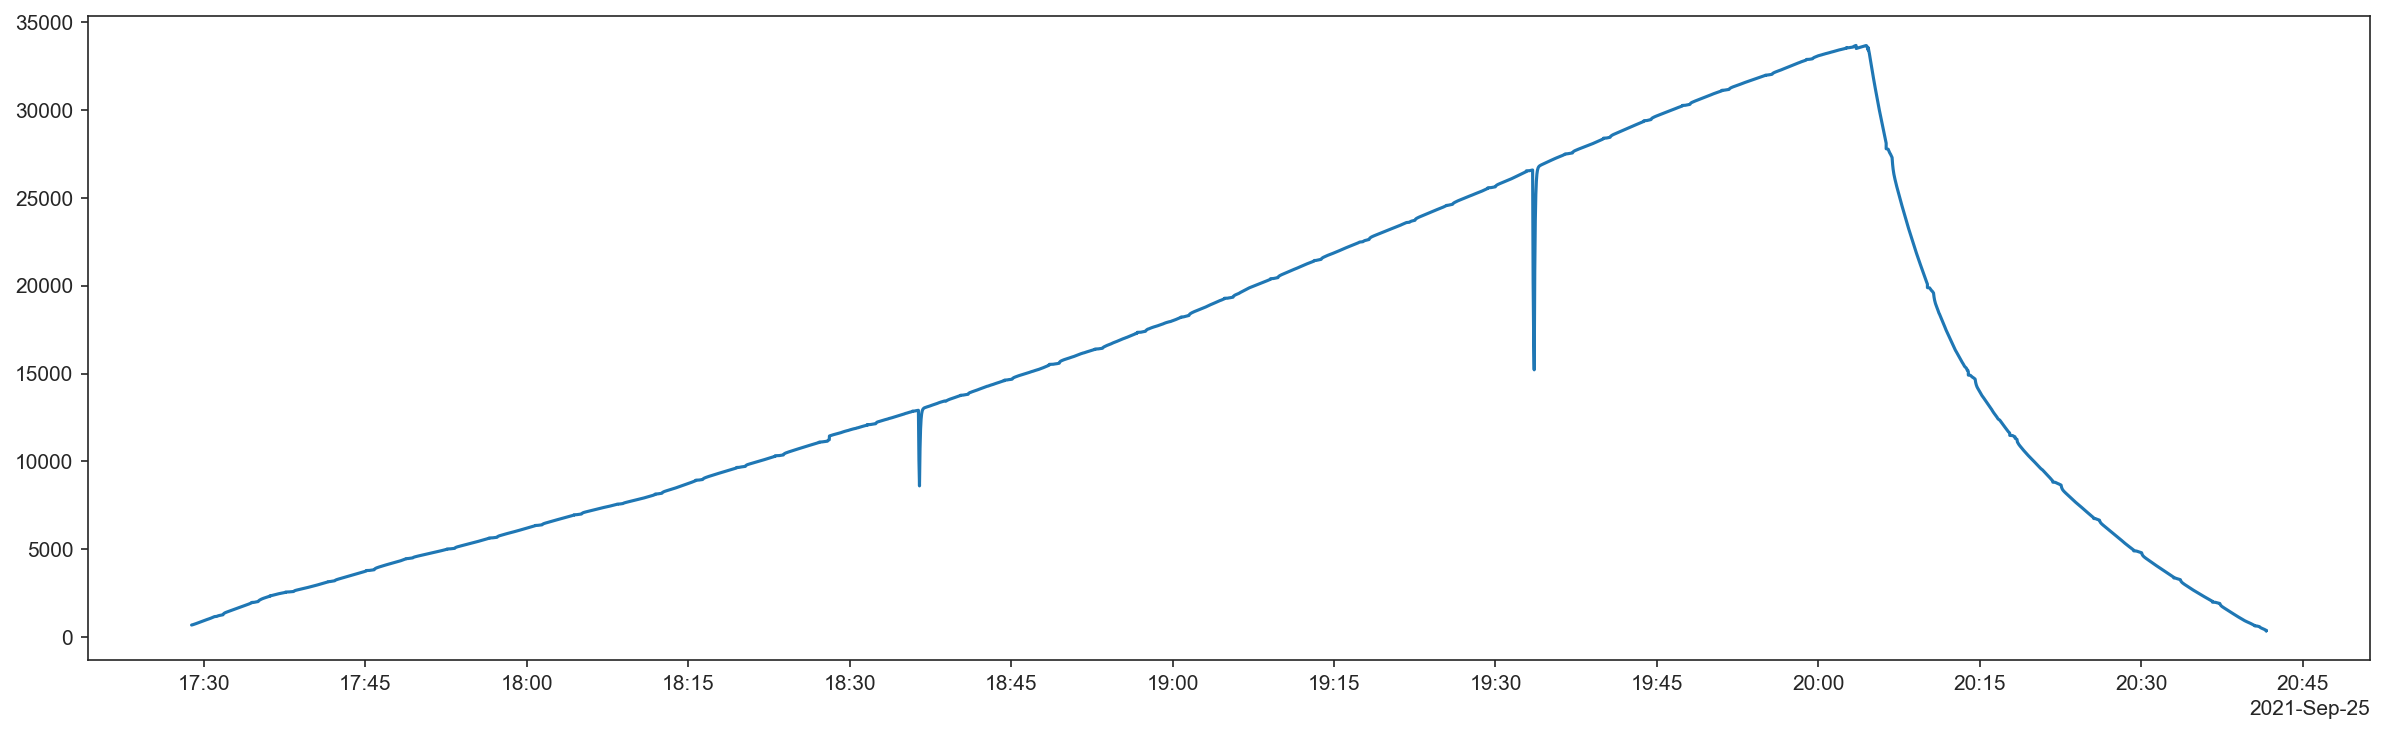

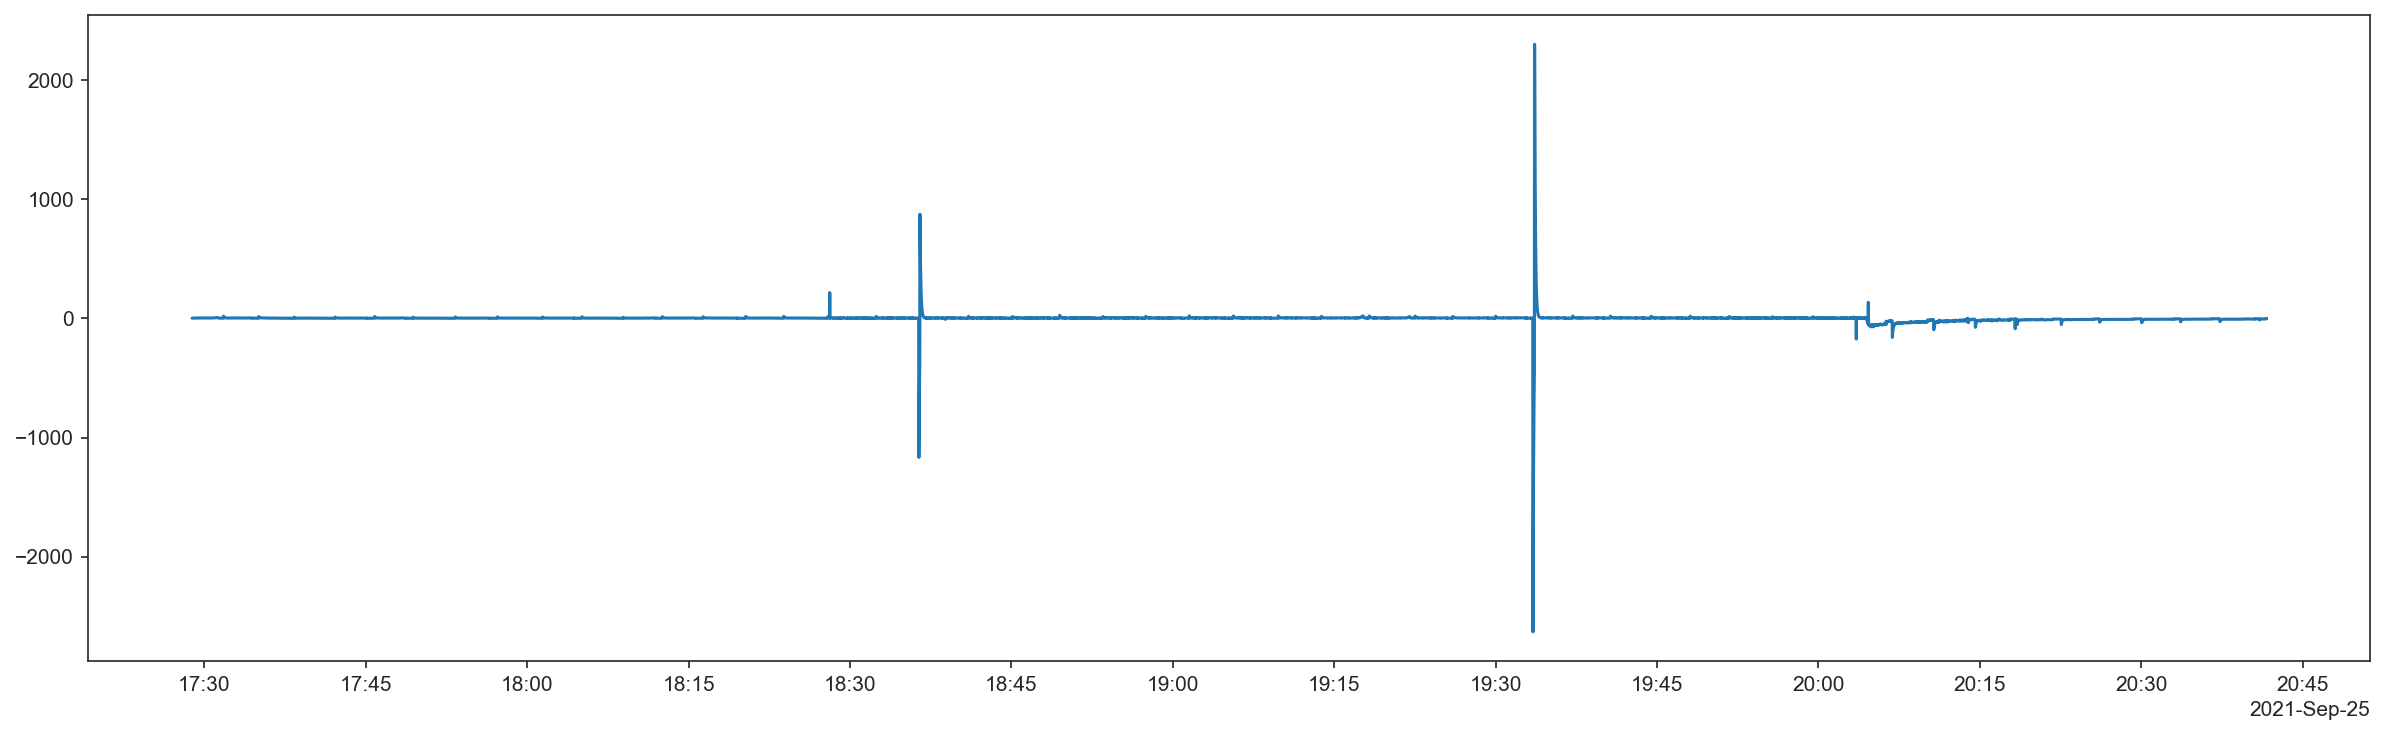

In [37]:
ax = pretty_plots()
ax.plot(mission_data['altitude_m'])

ax = pretty_plots()
ax.plot(mission_data['altitude_m'].diff());

## Altitude statistics

Finally, we can now compute some interesting altitude statistics and use them to answer some questions about our mission.

In [38]:
burst_altitude_index = np.argmax(mission_data['altitude_m'])
burst_altitude_m = mission_data['altitude_m'].max()
burst_altitude_ft = burst_altitude_m / 0.305

print("Burst altitude: {0:0.1f} meters ({1:0.1f} feet)".format(burst_altitude_m, burst_altitude_ft))

Burst altitude: 33678.2 meters (110420.3 feet)


In [39]:
ascent_rate = mission_data['altitude_m'].diff()

# We have a large discontinuity in our smoothed altitude due to sensor noise,
# so I'm going to clip that value from the data.
second_highest_ascent_rate = ascent_rate.nlargest(2)[-1]
mission_data['ascent_rate_mps'] = ascent_rate.clip(upper=second_highest_ascent_rate)

ascent_phase = mission_data[mission_data.index < burst_time].copy()
descent_phase = mission_data[mission_data.index > burst_time].copy()

print("Maximum ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].max()))
print("Average ascent rate: {0:0.2f} m/s".format(ascent_phase['ascent_rate_mps'].mean()))
print()
print("Maximum descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].min()*-1))
print("Average descent rate: {0:0.2f} m/s".format(descent_phase['ascent_rate_mps'].mean()*-1))

Maximum ascent rate: 1841.64 m/s
Average ascent rate: 3.52 m/s

Maximum descent rate: 158.79 m/s
Average descent rate: 4.46 m/s


/var/folders/gw/fwbnxl652jx80ff49ndt1x6jzjvjfq/T/ipykernel_86155/2190321210.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mission_data['ascent_rate_mps'] = ascent_rate.clip(upper=second_highest_ascent_rate)


Max speed: 200.70 m/s


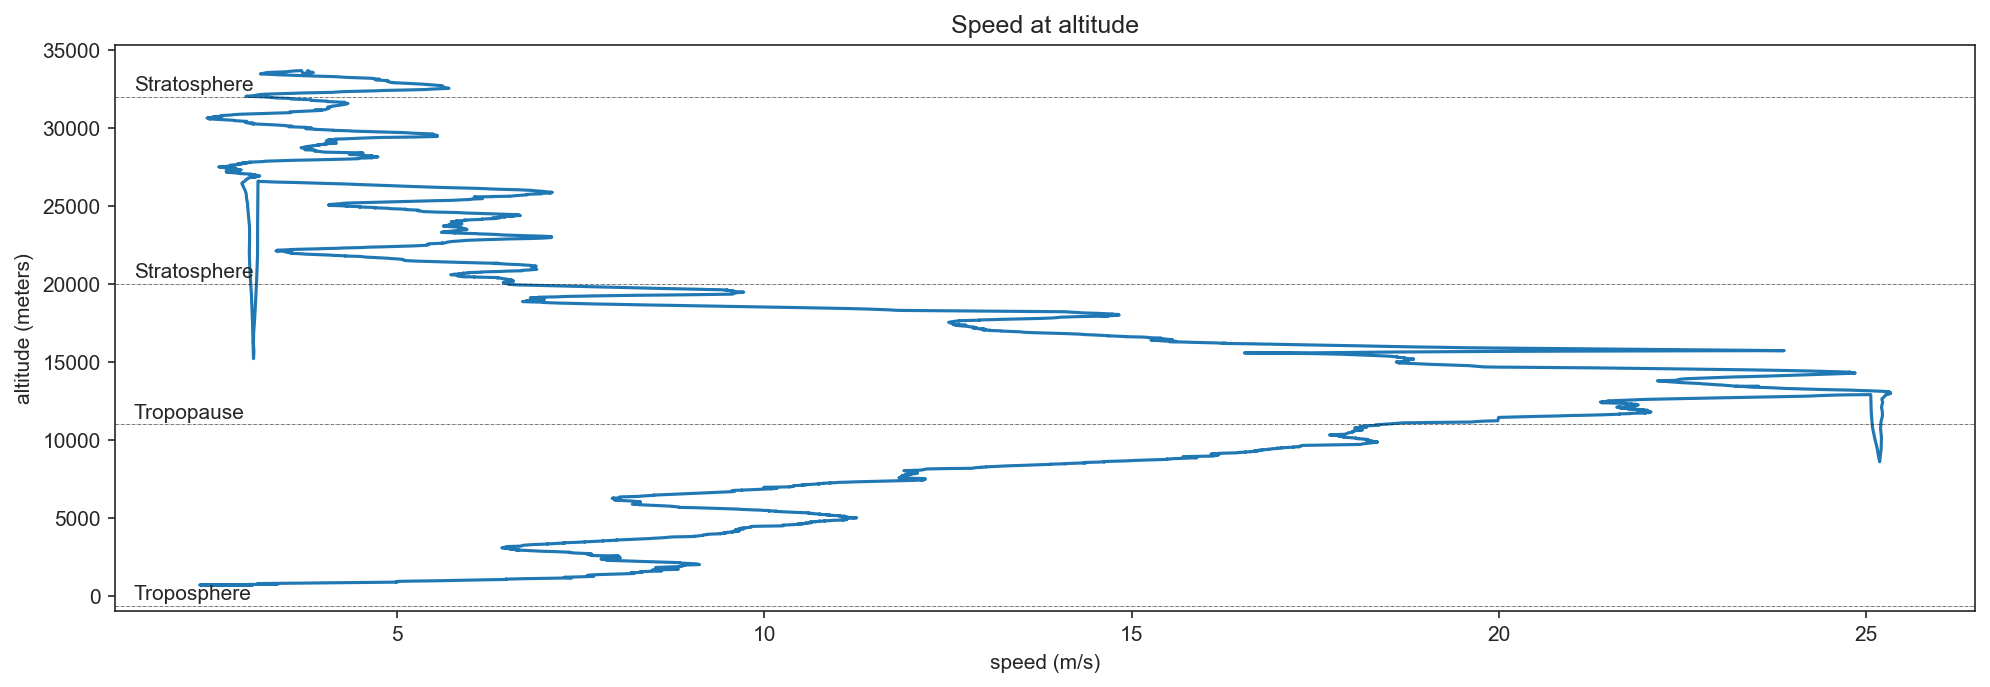

In [40]:
fig, ax = plt.subplots()

ax.plot(ascent_phase['speed_mps'].ewm(alpha=0.01).mean(), ascent_phase['altitude_m'])
annotate_layers(ax, label=True, max_layer=4)
ax.set_title("Speed at altitude")
ax.set_xlabel("speed (m/s)")
ax.set_ylabel("altitude (meters)")

max_speed = mission_data['speed_mps'].max()
print(f"Max speed: {max_speed:0.2f} m/s")

From the above data, we can see why our balloon travelled so far east from its predicted flight path. Our original estimated ascent rate was 4.9 m/s, but since we ran out of helium before hitting our target lift, our actual ascent rate averaged only 3.9 m/s.  This caused our balloon to drift through the jet stream for a longer period of time, where it was being blown around at a brisk **35 m/s (~80 mph)**!

## Parachute drag

One of our questions is why our balloon descended as quickly as it did.  We were using a 3' High Altitude Balloon Parachute from [the-rocketman.com](https://the-rocketman.com/recovery-html/).  Our payload weighed 1325 grams (2.9 lbs).  According to the parachute's specs, this should have put us a little over 20 feet per second **(6.1 m/s)** at 1 atmosphere.

Initial tests made us concerned that the descent rate was too high, so we conducted an experiment where we tossed the parachute off the Fremont bridge.  From analyzing the footage in slow motion, we were able to time the fall and measured a descent rate of between 6-7 m/s. A little high, but within our specs.

What did we measure?

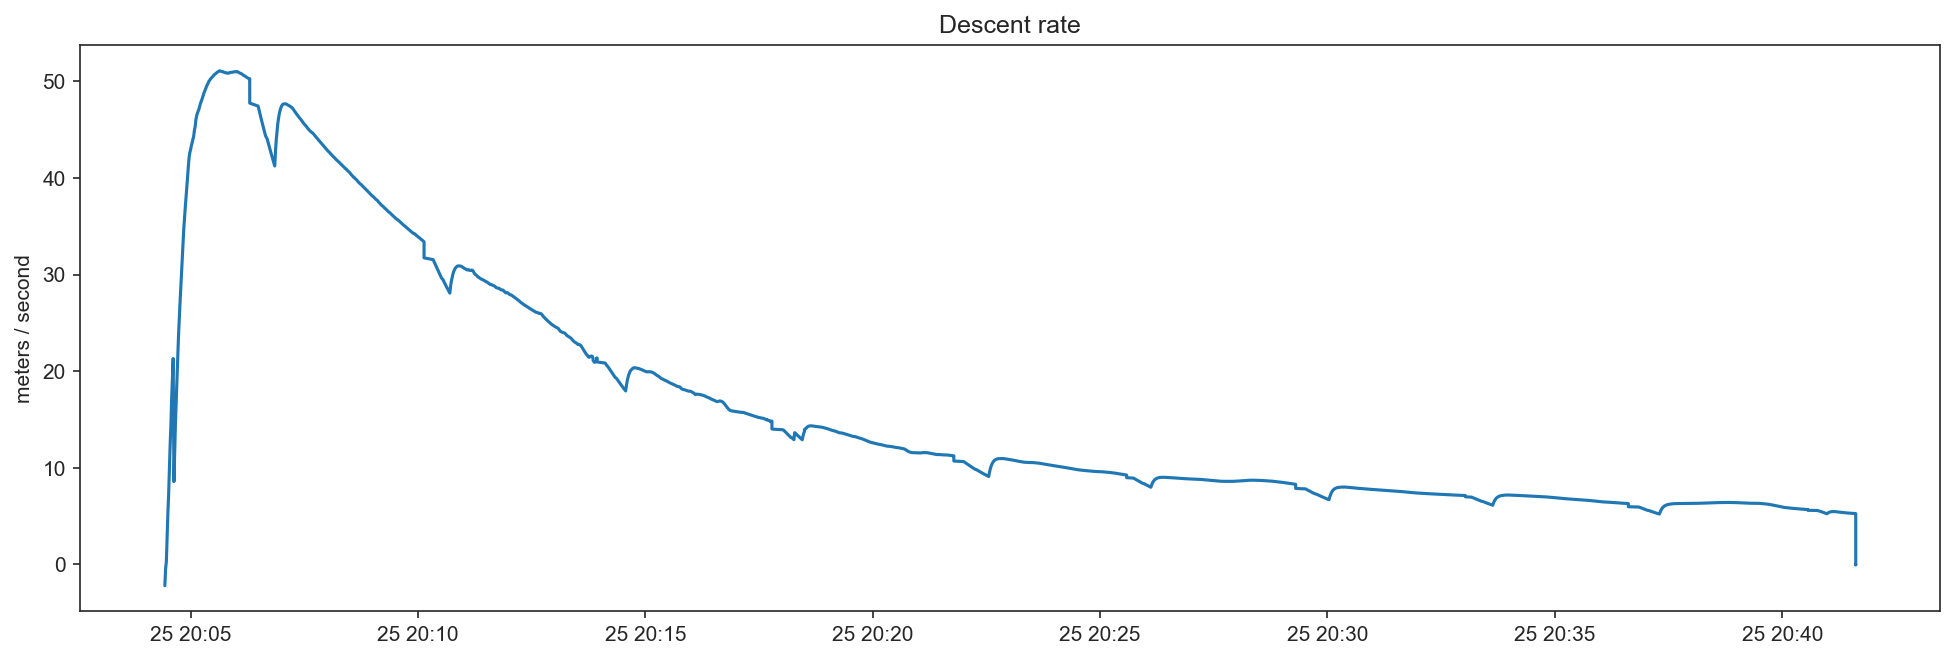

In [41]:
fig, ax = plt.subplots()

smoothed_descent_rate = descent_phase['ascent_rate_mps'].ewm(alpha=0.01).mean() * -1

ax.plot(smoothed_descent_rate)
ax.set_title("Descent rate")
ax.set_ylabel("meters / second")
plt.show()

In [46]:
# Write the missison data back out to a csv file.
mission_data.to_csv(directory + '/clean-data.csv')